In [1]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

import network
import utils

%matplotlib inline

In [2]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()

cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-06-10-42-45/'
#checkpoint-2018-03-02-16-31-42/'
width = 64
height = 64
nchannels = 1
channels = [0]
batchsize = 32
learning_rate = 0.00005

latent_size = 128
enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, height, width, nchannels))
z = tf.placeholder(tf.float32, (None, latent_size))

enc = network.encoder(images, latent_size, droprate=.7, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=nchannels, width=width, droprate=.7,
                      is_train=False, nfilters=dec_sizes)

loss = network.ae_loss(images, sdd, nchannels=nchannels,
                       latent_size=latent_size, width=width)

opt = network.model_opt(loss, learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + 'autoencoder-128x-18660.meta') #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 64, 64, 1) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 32, 32, 64) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_3:0' shape=(?, 4, 4, 512) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 128), dtype=float32)
isize:  4 64
[<tf.Tensor 'Maximum_4:0' shape=(?, 8192) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 512) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_6:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_7:0' shape=(?, 32, 32, 64) dtype=float32>] Tensor("decoder_out/BiasAdd:0", shape=(?, 64, 64, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-06-10-42-45/autoencoder-128x-18660


In [3]:
'''
Read in the data for the data table
'''

mm_name = "Fish5_13.tif.mm"
datadir = "/home/cjw/disk2cjw/Data/cyto/"
# mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
mmfilename = datadir + mm_name

mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

header_shape = mmheader.shape
print(header_shape, mmheader)
xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
#xshape[0] = 2400
xshape = tuple(xshape)
del mmheader

n = xshape[0]
ids =  range(n)
# file = n*['Fish6_15_cjw_64.tif']
file = n*[mm_name[:-3]]
print(file[0])
fid = range(n)
# mmfile = n*['Fish6_15_cjw_64.tif.mm']
mmfile = n*[mm_name]
plate = n*[0]
row = n*[0]
column = n*[0]
field = n*[0]
yc = n*[32]
xc = n*[32]
well = n*[0]

df = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                 'row':row, 'column':column, 'field':field,
                  'yc':yc, 'xc':xc, 'well':well})

df.head()

(4,) [10000    64    64     1]
Fish5_13.tif


,column,fid,field,file,id,mmfile,plate,row,well,xc,yc
0,0,0,0,Fish5_13.tif,0,Fish5_13.tif.mm,0,0,0,32,32
1,0,1,0,Fish5_13.tif,1,Fish5_13.tif.mm,0,0,0,32,32
2,0,2,0,Fish5_13.tif,2,Fish5_13.tif.mm,0,0,0,32,32
3,0,3,0,Fish5_13.tif,3,Fish5_13.tif.mm,0,0,0,32,32
4,0,4,0,Fish5_13.tif,4,Fish5_13.tif.mm,0,0,0,32,32


In [4]:
''' Read the memory map file'''

mf = df['mmfile']
umf = list(mf.unique())
print(umf)
#df = df.replace(umf, ["plate03_all.mm"])

m2 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)

# mmdict = {"Fish_15_cjw_64.tif.mm": m2}
mmdict = {mm_name: m2}

['Fish5_13.tif.mm']


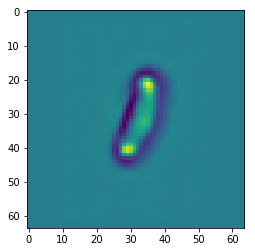

In [5]:
'''Just show a sample image to make sure everything is working'''

plt.imshow(m2[41,:,:,0])

10000
(10000, 128) (10000, 64, 64, 1)
-0.262019634247 1.32013678551
2368
8356
1732
7763
465


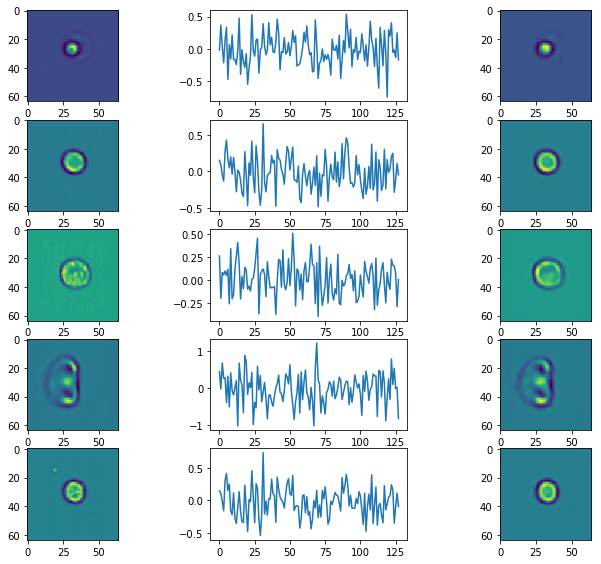

In [6]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, width, 0, 0, nchannels, channels=channels)

print(len(vv))
xhe = sess.run(enc, feed_dict={images:vv})
xdd = sess.run(sdd, feed_dict={enc:xhe})
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])
   

In [7]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = sess.run(enc, feed_dict={images:k})
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
10000
0 0 (10000, 128) (10000, 128)


(10000, 128)

In [8]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (.5, .5, .5),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.] 8


In [9]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=32, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(10000, 32)
[ 0.86736554  0.68291476  0.54925856  0.52163696  0.45206242  0.44146281
  0.3976643   0.37812824  0.36853038  0.35433535  0.33361664  0.32087742
  0.3042689   0.29579137  0.28294271  0.27044216  0.25610237  0.24709738
  0.23752483  0.23590965  0.22419168  0.21964647  0.21435513  0.20546879
  0.19720387  0.19239876  0.18520385  0.18040441  0.18017651  0.16583348
  0.16280755  0.16183947]
(32, 128)


In [106]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 8
from sklearn import cluster

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

0 760
1 1338
2 3145
3 1578
4 1116
5 753
6 232
7 1078


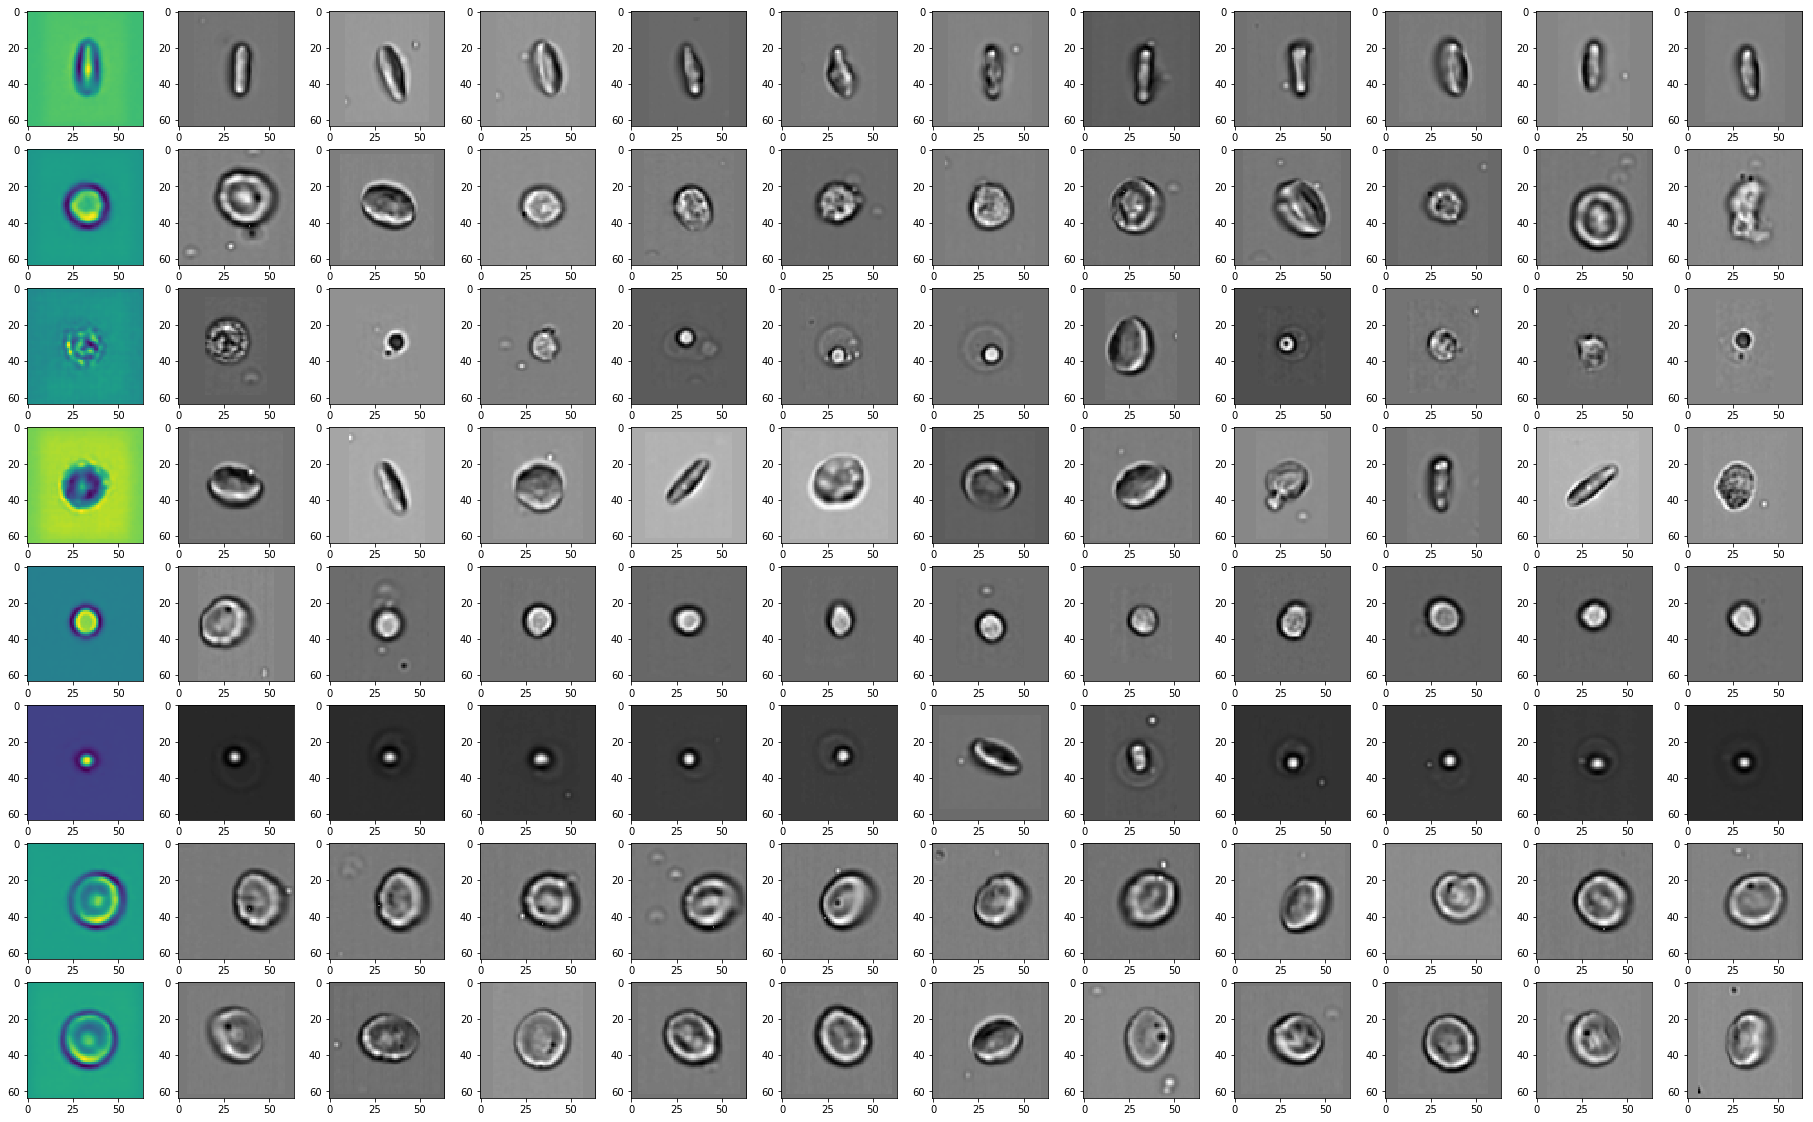

In [107]:
ximages = vv
ximages.shape

nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    row = ximages[km == k]

    print(k, row.shape[0])
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze())
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = np.random.randint(0,len(row))
            plt.imshow(row[rnd,:,:,0], cmap='gray')
        except:
            plt.imshow(np.zeros((64,64)))

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

0 153
1 38
2 177
3 158
4 24
5 231
6 111
7 182
8 237
9 314
10 423
11 136
12 204
13 59
14 109
15 138
16 244
17 111
18 124
19 178
20 78
21 1617
22 88
23 90
24 163
25 168
26 124
27 93
28 109
29 83
30 31
31 52
32 316
33 77
34 143
35 58
36 76
37 16
38 133
39 111
40 69
41 134
42 105
43 295
44 69
45 71
46 122
47 51
48 193
49 74
50 48
51 121
52 108
53 87
54 194
55 138
56 67
57 123
58 124
59 73
60 275
61 355
62 58
63 69


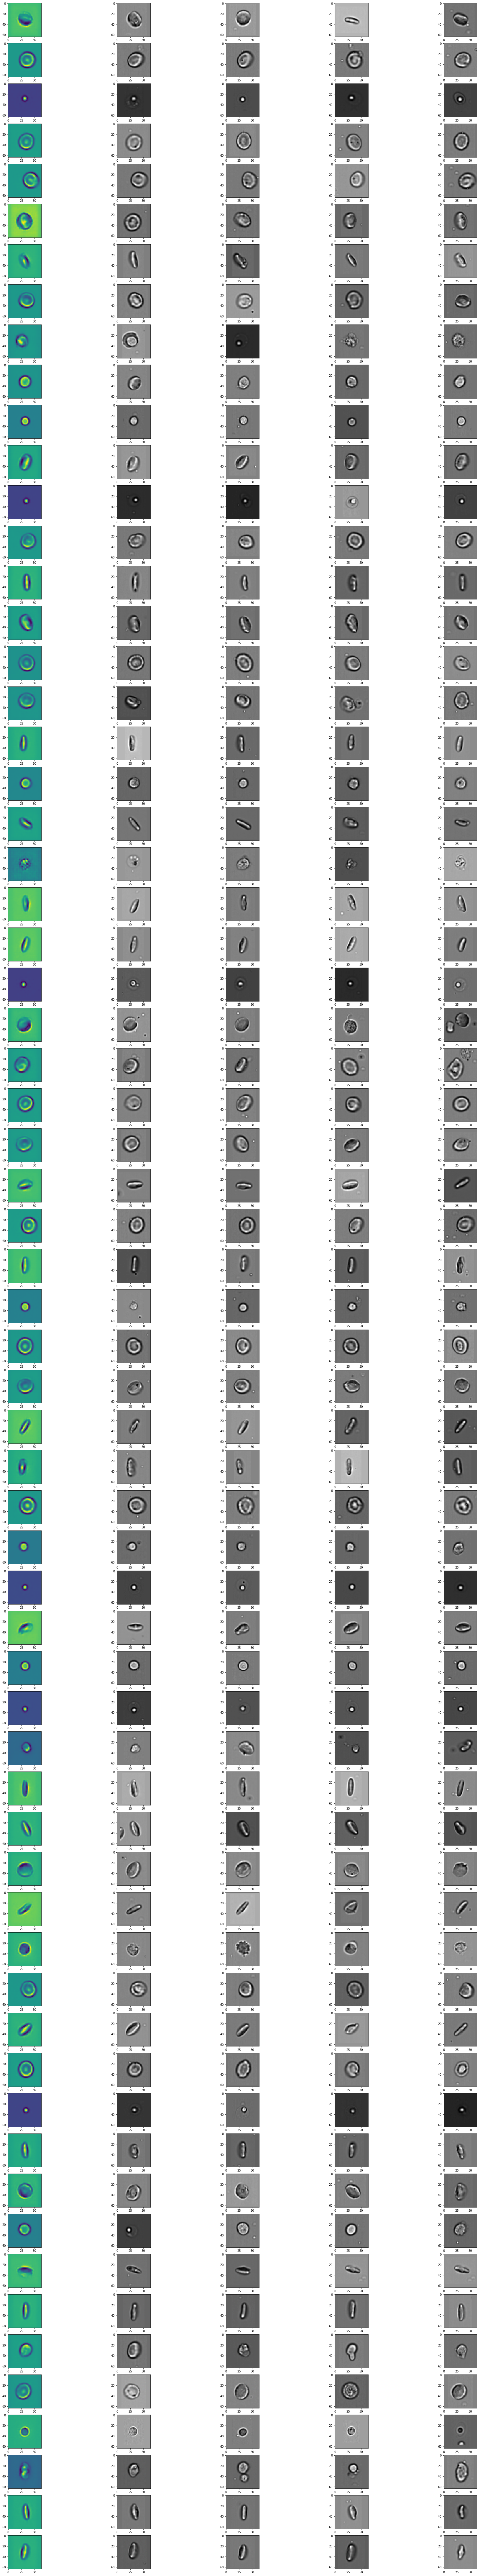

In [92]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    row = ximages[agc == k]
    print(k, row.shape[0])
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 5, counter)
    plt.imshow(resav.squeeze())
    counter += 1
    for i in range(4):
        plt.subplot(nk, 5, counter)
        counter += 1
        try:
            rnd = np.random.randint(0,len(row))
            plt.imshow(row[rnd,:,:,0], cmap='gray')
        except:
            plt.imshow(np.zeros((64,64)))

-------------------------------------------------------------------------

(1169, 64, 64, 1)


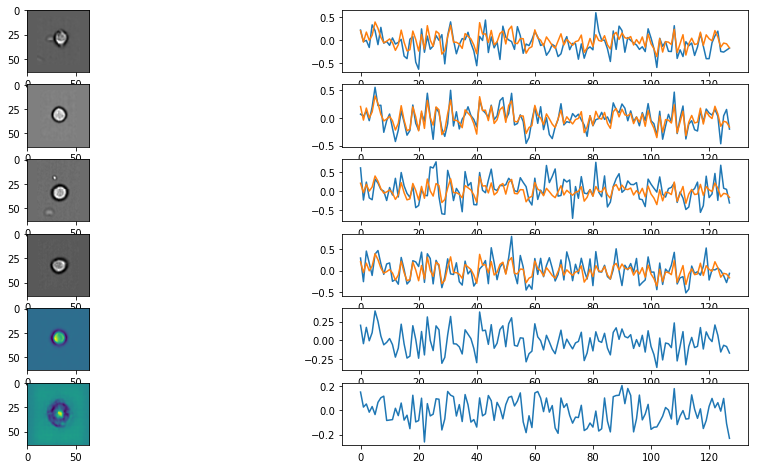

In [45]:
tn = 5
images4 = ximages[agc == tn]
g4 = g_all[agc == tn]
plt.figure(figsize=(16,8))
print(images4.shape)

gtest = np.mean(g4, axis=0)
gtest = np.expand_dims(gtest.squeeze(), axis=0)
res = sess.run(sdd, feed_dict={enc:gtest})

gav = np.mean(g_all, axis=0)
gav = np.expand_dims(gav.squeeze(), axis=0)
resav = sess.run(sdd, feed_dict={enc:gav})

ppi = 0
for i in range(4):
    ix = np.random.randint(0, len(g4))
    plt.subplot(6,2,i*2 + 1)
    plt.imshow(images4[ix,:,:,0], cmap='gray')
    plt.subplot(6,2, i*2 + 2)
    plt.plot(g4[ix,:])
    plt.plot(gtest.squeeze())
    ppi += 2

plt.subplot(6,2, ppi+ 1 )
plt.imshow(res.squeeze())
plt.subplot(6,2, ppi + 2)
plt.plot(gtest.squeeze())
plt.subplot(6,2, ppi + 3)
plt.imshow(resav.squeeze())
plt.subplot(6,2, ppi + 4)
plt.plot(gav.squeeze())


In [57]:
from sklearn.manifold import TSNE
gn = g_all[agc != 4]
print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=30, learning_rate=500).fit_transform(gn.astype(np.float64))
print(g_emb.shape)



(7265, 128)
(7265, 2)


(10000,)
(7265,)
(10000,)


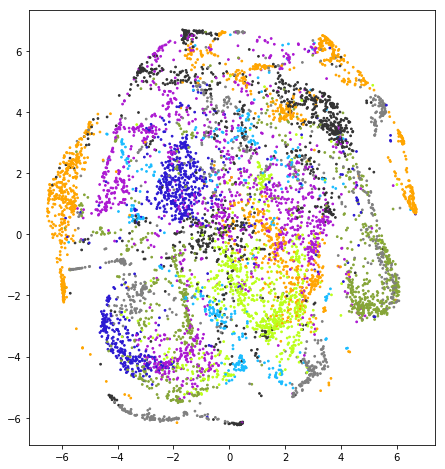

In [58]:
print(agc.shape)
print(agc[agc !=4].shape)
clist3 = clist*3
#cykm = [clist[z] for z in km[km !=4]]
cya = [clist3[z] for z in agc[agc != 4]]

print(colors.shape)
#from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,8))
# plt.subplot(121)
# plt.scatter(g_emb[:,0], g_emb[:,1], s=3, c=cykm)
plt.subplot(122)
plt.scatter(g_emb[:,0], g_emb[:,1], s=3, c=cya)

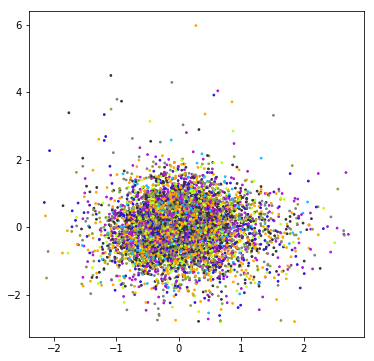

In [59]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sc = ax.scatter(gfit[agc != 3][:,0], gfit[agc != 3][:,1], s=3, c=cya)

(753, 128) (753, 64, 64, 1)
0 97
1 109
2 158
3 9
4 130
5 35
6 125
7 90


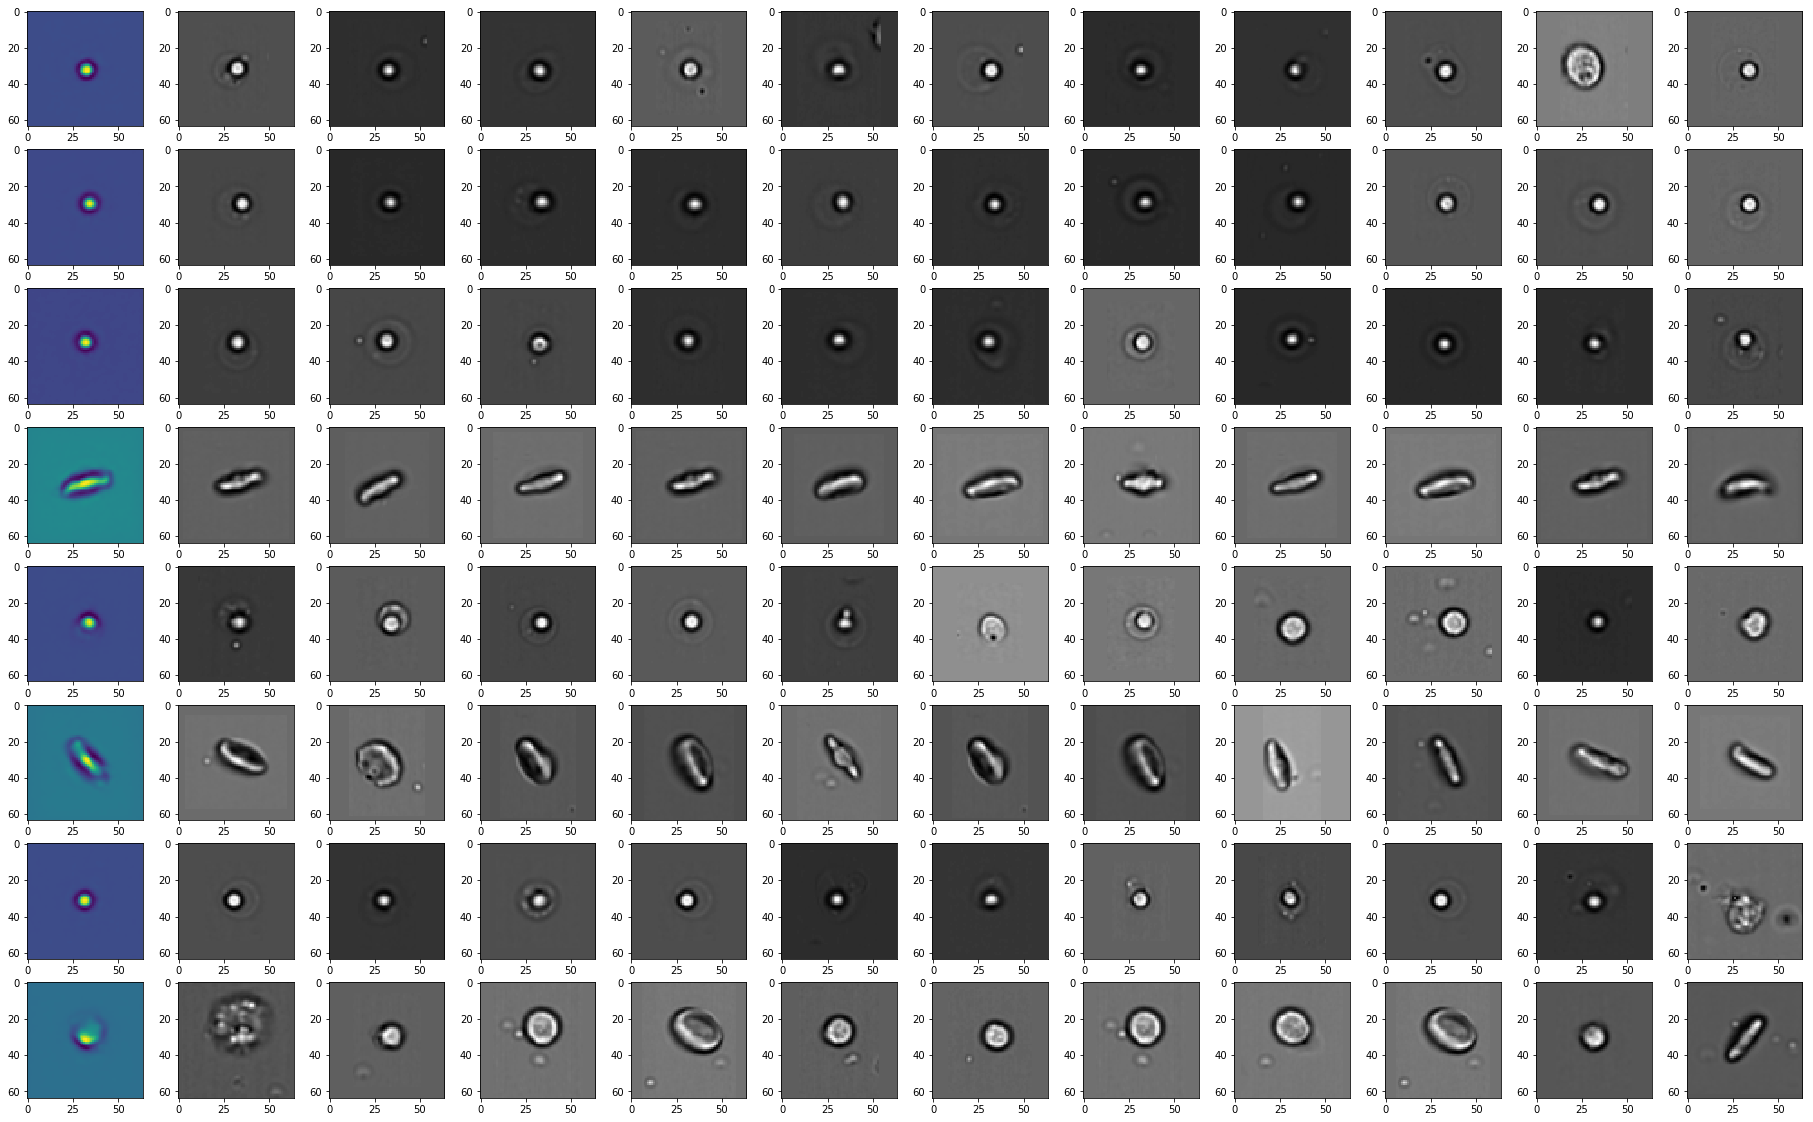

In [118]:
ain = 5
row4 = ximages[km == ain]
g4 = g_all[km == ain]
print(g4.shape, row4.shape)
agc4 = cluster.AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage="ward").fit_predict(g4)
agc4 = cluster.KMeans(n_clusters=8).fit_predict(g4)

nk = 8
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    row = row4[agc4 == k]
    print(k, row.shape[0])
    gk = g4[agc4 == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze())
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = np.random.randint(0,len(row))
            plt.imshow(row[rnd,:,:,0], cmap='gray')
        except:
            plt.imshow(np.zeros((64,64)))

In [119]:
from sklearn.manifold import TSNE
g_emb4 = TSNE(n_components=2,perplexity=50, learning_rate=500).fit_transform(g4.astype(np.float64))



(10000,)


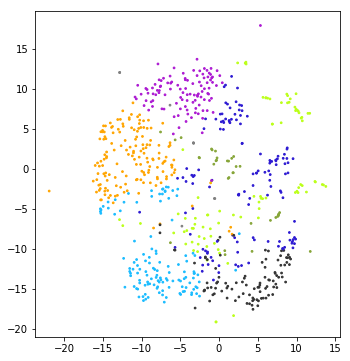

In [120]:
#cykm = [clist[z] for z in km]
cya4 = [clist[z] for z in agc4]

print(colors.shape)
#from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(g_emb4[:,0], g_emb4[:,1], s=3, c=cya4)
